### Stacking Variational Bayesian Monte Carlo (S-VBMC)

This notebook shows the usage of the `SVBMC` class to stack posteriors from different Variational Bayesian Monte Carlo (VBMC) runs, optimizing the Evidence Lower BOund (ELBO) of the resulting stacked posterior ($\text{ELBO}_{\text{stacked}}$). This is useful when separate VBMC runs give different results, i.e. when VBMC discovers different portions of the posterior in different runs.

Let's start with imports. 

In [1]:
import pickle
from svbmc import SVBMC
from visual import overlay_corner_plot # plots overlayed distributions from samples
import numpy as np
import glob


#### Example 1: Multimodal target

One situation in which VBMC is likely to yield suboptimal results is when the target distribution has multiple, distant modes. We use this as our first example, showcasing how, while VBMC tends to get stuck overexploring the parameter region around an individual mode, stacking different (randomly initialized) runs manages to cature the full distribution effectively.

Let's start by plotting our target using samples taken directly from it.


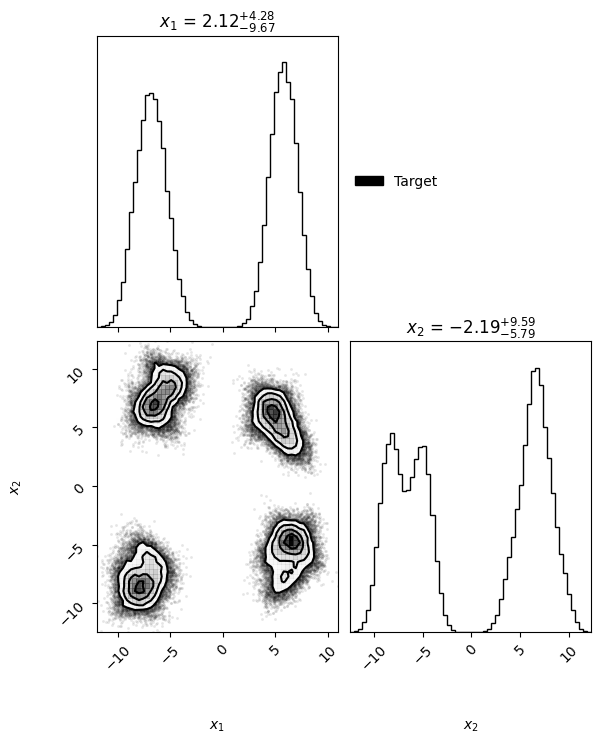

In [2]:
X_gmm_gt = np.loadtxt("samples/gmm_D_2_GT.csv", # path to file
                    delimiter=",", # CSV uses commas
                    dtype=float)            
                         
_ = overlay_corner_plot(
    [X_gmm_gt], # list of samples, just one in this case
    label = ["Target"], # label for legend
    color = ["black"], # colour for plot
    base = 4, # make it a bit bigger since it's only 2D
    bins = 60
    )

Now let's load a few `vp` objects output from different VBMC runs (refer to the [PyVBMC repository](https://github.com/acerbilab/pyvbmc/tree/main) for details). 

In [3]:
# Load variational posteriors
vp_list_gmm = []

vp_files_gmm = glob.glob("vbmc_runs/GMM/*.pkl") # change if necessary
vp_list_gmm = []

for file in vp_files_gmm:
    with open(file, "rb") as f:
        vp_list_gmm.append(pickle.load(f))


Let's plot a couple of posteriors (overlayed with the ground truth) to see how VBMC did.

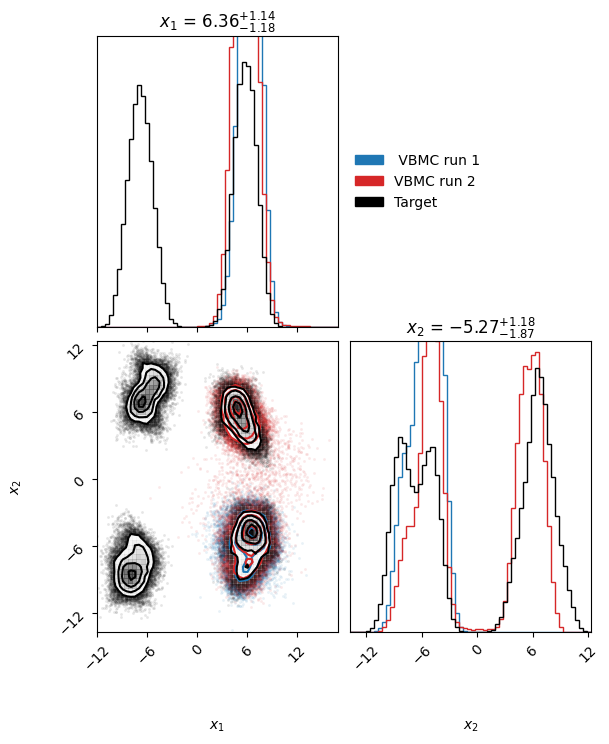

In [4]:
# Take samples
vbmc_samples_gmm = []

for m in range(2):
    Xs, _ = vp_list_gmm[m].sample(X_gmm_gt.shape[0]) # same number of samples as the ground truth
    vbmc_samples_gmm.append(Xs)

# Plot
_ = overlay_corner_plot(vbmc_samples_gmm + [X_gmm_gt], 
                        label = [" VBMC run 1", "VBMC run 2", "Target"], 
                        color = ["tab:blue", "tab:red", "black"], 
                        base=4, 
                        bins=60)

We can see that in both cases VBMC has missed some high mass probability regions, remaining stuck on one (or two) modes. 

Let's see if S-VBMC can fix this. Given a list of vp object obtained by running VBMC multiple times (here `vp_list`), our approach can be implelmented in a few lines of code.

**NOTE**: One should only use properly converged VBMC runs as input for S-VBMC. Luckily, [PyVBMC](https://github.com/acerbilab/pyvbmc/tree/main) offers good diagnostic tools to determine this, so it's easy to set up a filter. We found that filtering out runs not marked as "stable" and with excessive uncertainty in the estimation of the expected log-joint under individual components (see paper for details) works well. 

In [ ]:
# Filtering out bad runs, if present
before_filter = len(vp_list_gmm) 
vp_list_gmm = [vp for vp in vp_list_gmm if (vp.stats['stable'] and np.max(vp.stats['J_sjk']) < 5)]
after_filter = len(vp_list_gmm) 
print(f"{before_filter-after_filter} bad runs removed \n\n")

# Initialize SVBMC object
vp_stacked_gmm = SVBMC(vp_list=vp_list_gmm)

# Optimize stacked ELBO
vp_stacked_gmm.optimize()

print(f'Stacked ELBO: {vp_stacked_gmm.elbo["estimated"]}') # The target is noiseless, so there is no need for debiasing

0 bad runs removed 


Optimising the stacked ELBO w.r.t. all weights
Initial elbo = 2.974886914311729
iter 5: elbo = 2.9832148725557355
Stacked ELBO: 3.0054499224230646


Let's visualize the stacked posterior and see how it compares to the ground truth.


**IMPORTANT NOTE**: 

Users must use samples from the stacked posterior for any application and should **not** interpret its individual components (means and covariances).

This is because each VBMC run may use different internal parameter transformations. Consequently, the means and covariance matrices from different VBMC posteriors exist in **incompatible parameter spaces**. Combining them creates a mixture whose individual Gaussian components are not directly meaningful.

**Always use samples from the final stacked posterior**, which are correctly transformed back into the original parameter space. These are available via the `.sample()` method:

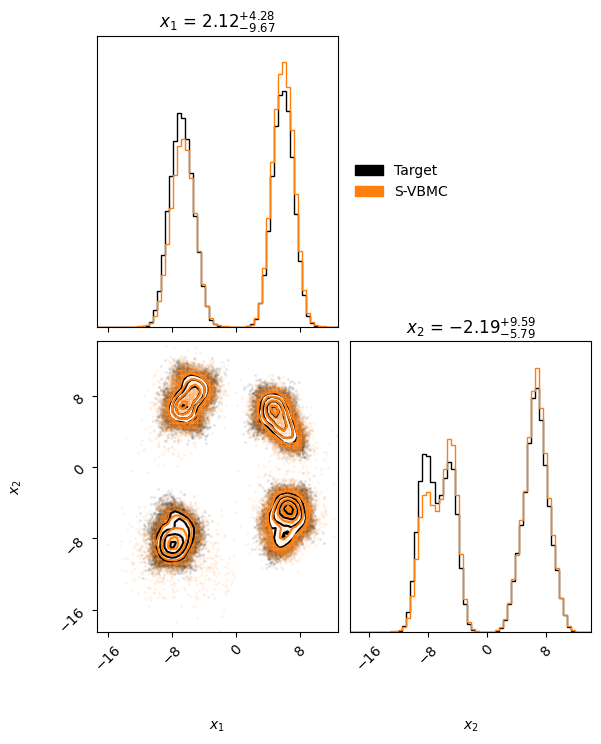

In [6]:
# Take samples from stacked posterior
svbmc_samples_gmm = vp_stacked_gmm.sample(X_gmm_gt.shape[0])

_ = overlay_corner_plot(
        samples = [X_gmm_gt, svbmc_samples_gmm], 
        label = ["Target", "S-VBMC"], 
        color = ["black", "tab:orange"], 
        base = 4, 
        bins = 60
        )

The stacked posterior should now cover all four modes, showing a very good match with the ground truth. Let's now try another example.

#### Example 2: Ring target

Another situation in which VBMC is likely to perform poorly is when the target distribution is long and slim. Here we use a ring-shaped target, let' have a look at it. Here we use samples obtained with MCMC as the ground truth.


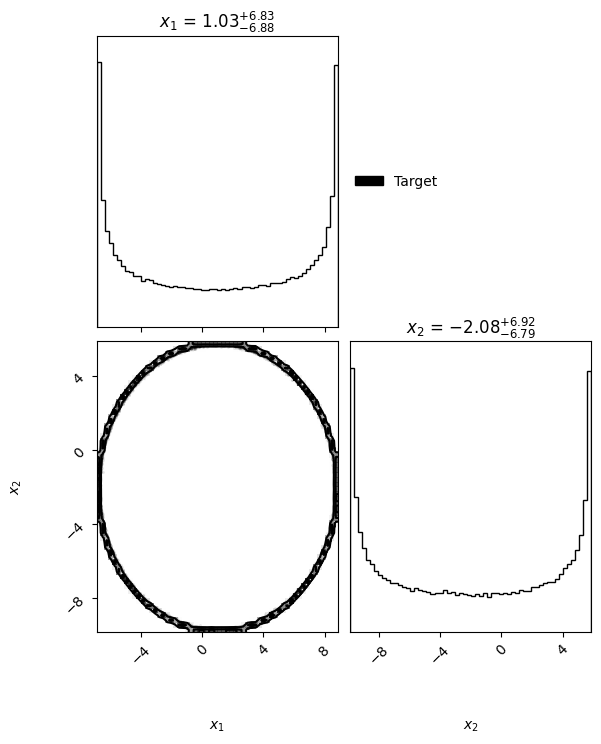

In [7]:
X_ring_gt = np.loadtxt("samples/ring_D_2_GT.csv", # path to file
                    delimiter=",", # CSV uses commas
                    dtype=float)            
                         
_ = overlay_corner_plot(
    [X_ring_gt], # list of samples, just one in this case
    label = ["Target"], # label for legend
    color = ["black"], # colour for plot
    base = 4, # make it a bit bigger since it's only 2D
    bins = 60
    )

As before, let's have a look at VBMC results.

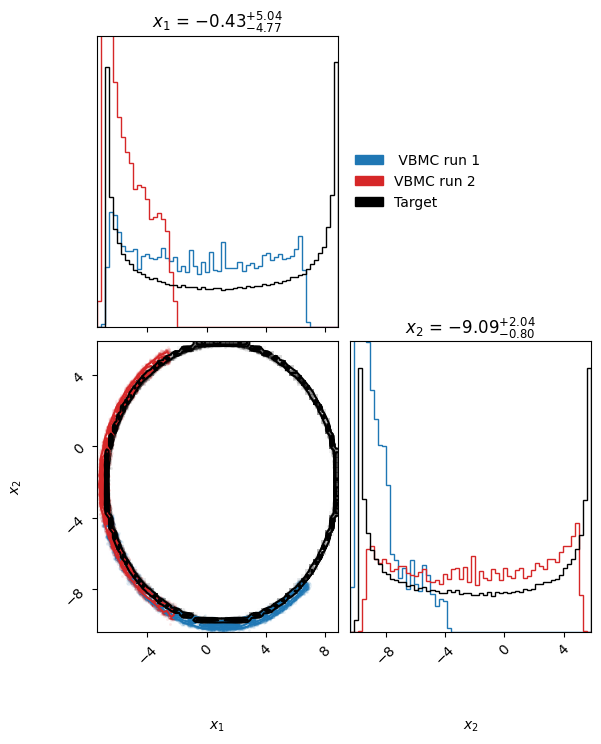

In [8]:
# Load variational posteriors
vp_list_ring = []

vp_files_ring = glob.glob("vbmc_runs/Ring/*.pkl") # change if necessary
vp_list_ring = []

for file in vp_files_ring:
    with open(file, "rb") as f:
        vp_list_ring.append(pickle.load(f))


# Take samples
vbmc_samples_ring = []

for m in range (2):
    Xs, _ = vp_list_ring[m].sample(X_ring_gt.shape[0]) # same number of samples as the ground truth
    vbmc_samples_ring.append(Xs)

# Plot
_ = overlay_corner_plot(samples = vbmc_samples_ring + [X_ring_gt], 
                        label = [" VBMC run 1", "VBMC run 2", "Target"], 
                        color = ["tab:blue", "tab:red", "black"], 
                        base=4, 
                        bins=60 
                        )

Again, VBMC fails to explore the whole posterior. Let's see if S-VBMC improves things.

0 bad runs removed 


Optimising the stacked ELBO w.r.t. all weights
Initial elbo = 2.2228045792613234
iter 5: elbo = 2.2743975496733713
iter 10: elbo = 2.2796517905853744
iter 15: elbo = 2.281340462101568
iter 20: elbo = 2.2874212985603535
Stacked ELBO: 2.2943833203087167


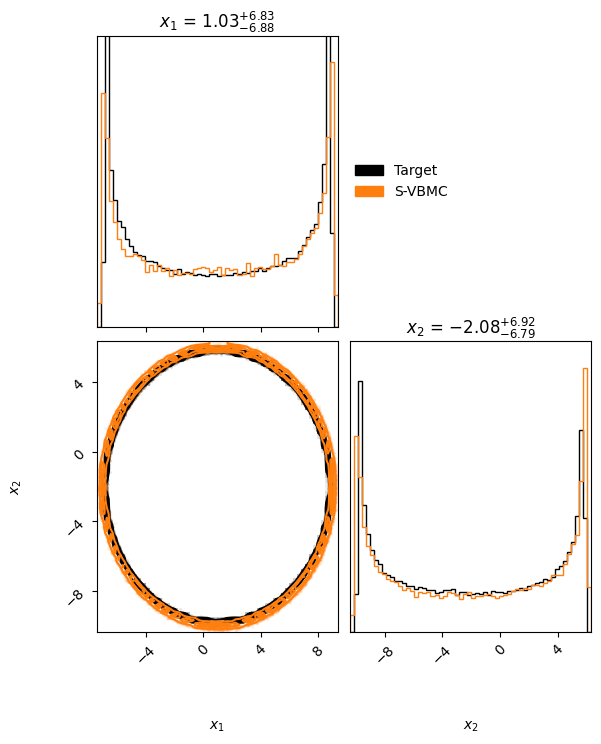

In [ ]:
# Filtering out bad runs, if present
before_filter = len(vp_list_ring) 
vp_list_ring = [vp for vp in vp_list_ring if (vp.stats['stable'] and np.max(vp.stats['J_sjk']) < 5)]
after_filter = len(vp_list_ring) 
print(f"{before_filter-after_filter} bad runs removed \n\n")

# Initialize SVBMC object
vp_stacked_ring = SVBMC(vp_list=vp_list_ring)

# Optimize stacked ELBO
vp_stacked_ring.optimize()

print(f'Stacked ELBO: {vp_stacked_ring.elbo["estimated"]}')

# Take samples from stacked posterior
svbmc_samples_ring = vp_stacked_ring.sample(X_ring_gt.shape[0])

_ = overlay_corner_plot(
        samples = [X_ring_gt, svbmc_samples_ring], 
        label = ["Target", "S-VBMC"], 
        color = ["black", "tab:orange"], 
        base = 4, 
        bins = 60
        )

As before, S-VBMC effectively combined VBMC posteriors into an accurate global approximation of the true target.